In [1]:
import strax
import straxen
from tight_coincidence import *

<module 'strax' from '/home/jh3226/software/strax/strax/__init__.py'>


In [2]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from multihist import Histdd
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size': 18})

In [3]:
st = straxen.contexts.strax_workshop_dali()
st.register(TightCoincidence)

tight_coincidence.TightCoincidence

In [4]:
dsets = st.select_runs(include_tags='sciencerun2_preliminary', 
                       exclude_tags='?fterNG',
                       available='raw_records', 
                       run_mode='background*')
len(dsets)
n_runs = 5
dsets_sample = dsets.head(n_runs)
run_ids = dsets_sample.name.values.tolist()[0]
print(run_ids)

Checking data availability: 100%|██████████| 5/5 [00:04<00:00,  1.46it/s]

180215_1029


In [5]:
peaks = st.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification', 'tight_coincidence'], config=dict(filter=None))

peaks_filtered = st.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification', 'tight_coincidence'])


Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called
Peaks.compute() is being called


In [7]:
import numba

def index_of_fraction(peaks, fractions_desired):
    # nopython does not allow this dynamic allocation:
    results = np.zeros((len(peaks), len(fractions_desired)), dtype=np.float)
    _index_of_fraction(peaks, fractions_desired, results)
    return results

@numba.jit(nopython=True, nogil=True, cache=True)
def _index_of_fraction(peaks, fractions_desired, results):
    for p_i, p in enumerate(peaks):
        area_tot = p['area']
        if area_tot <= 0:
            continue  # TODO: These occur a lot. Investigate!
        r = results[p_i]

        fraction_seen = 0
        current_fraction_index = 0
        needed_fraction = fractions_desired[current_fraction_index]
        for i, x in enumerate(p['data'][:p['length']]):
            # How much of the area is in this sample?
            fraction_this_sample = x / area_tot

            # Are we passing any desired fractions in this sample?
            while fraction_seen + fraction_this_sample >= needed_fraction:

                area_needed = area_tot * (needed_fraction - fraction_seen)
                if x != 0:
                    r[current_fraction_index] = i + area_needed / x
                else:
                    r[current_fraction_index] = i

                # Advance to the next fraction
                current_fraction_index += 1
                if current_fraction_index > len(fractions_desired) - 1:
                    break
                needed_fraction = fractions_desired[current_fraction_index]

            if current_fraction_index > len(fractions_desired) - 1:
                break

            # Add this sample's area to the area seen
            fraction_seen += fraction_this_sample

        if needed_fraction == 1:
            # Sometimes floating-point errors prevent the full area
            # from being reached before the waveform ends
            r[-1] = p['length']

    return results


def compute_widths(peaks):
    """Compute widths in ns at desired area fractions for peaks
    returns (n_peaks, n_widths) array
    """
    if not len(peaks):
        return

    desired_widths = np.linspace(0, 1, len(peaks[0]['width']))
    # 0% are width is 0 by definition, and it messes up the calculation below
    desired_widths = desired_widths[1:]

    # Which area fractions do we need times for?
    desired_fr = np.concatenate([0.5 - desired_widths / 2,
                                 0.5 + desired_widths / 2])

    # We lose the 50% fraction with this operation, let's add it back
    desired_fr = np.sort(np.unique(np.append(desired_fr, [0.5])))

    fr_times = index_of_fraction(peaks, desired_fr)
    fr_times *= peaks['dt'].reshape(-1, 1)

    i = len(desired_fr) // 2
    peaks['width'] = fr_times[:, i:] - fr_times[:, ::-1][:, i:]
    return fr_times[:, ::2] - fr_times[:, i].reshape(-1,1)

In [8]:
myarr = np.zeros(len(peaks), dtype=[('area_decile_from_midpoint', np.float32, (11,))])
myarr[:]['area_decile_from_midpoint'] = compute_widths(peaks)

In [9]:
peaks = strax.utils.merge_arrs([peaks, myarr])

In [10]:
peaks.dtype.names

('channel',
 'dt',
 'time',
 'length',
 'area',
 'area_per_channel',
 'n_hits',
 'data',
 'width',
 'area_decile_from_midpoint',
 'saturated_channel',
 'n_saturated_channels',
 'endtime',
 'n_channels',
 'max_pmt',
 'max_pmt_area',
 'range_50p_area',
 'area_fraction_top',
 'type',
 'tight_coincidence')

In [11]:
len(peaks)

49742

In [12]:
run_ids

'180215_1029'

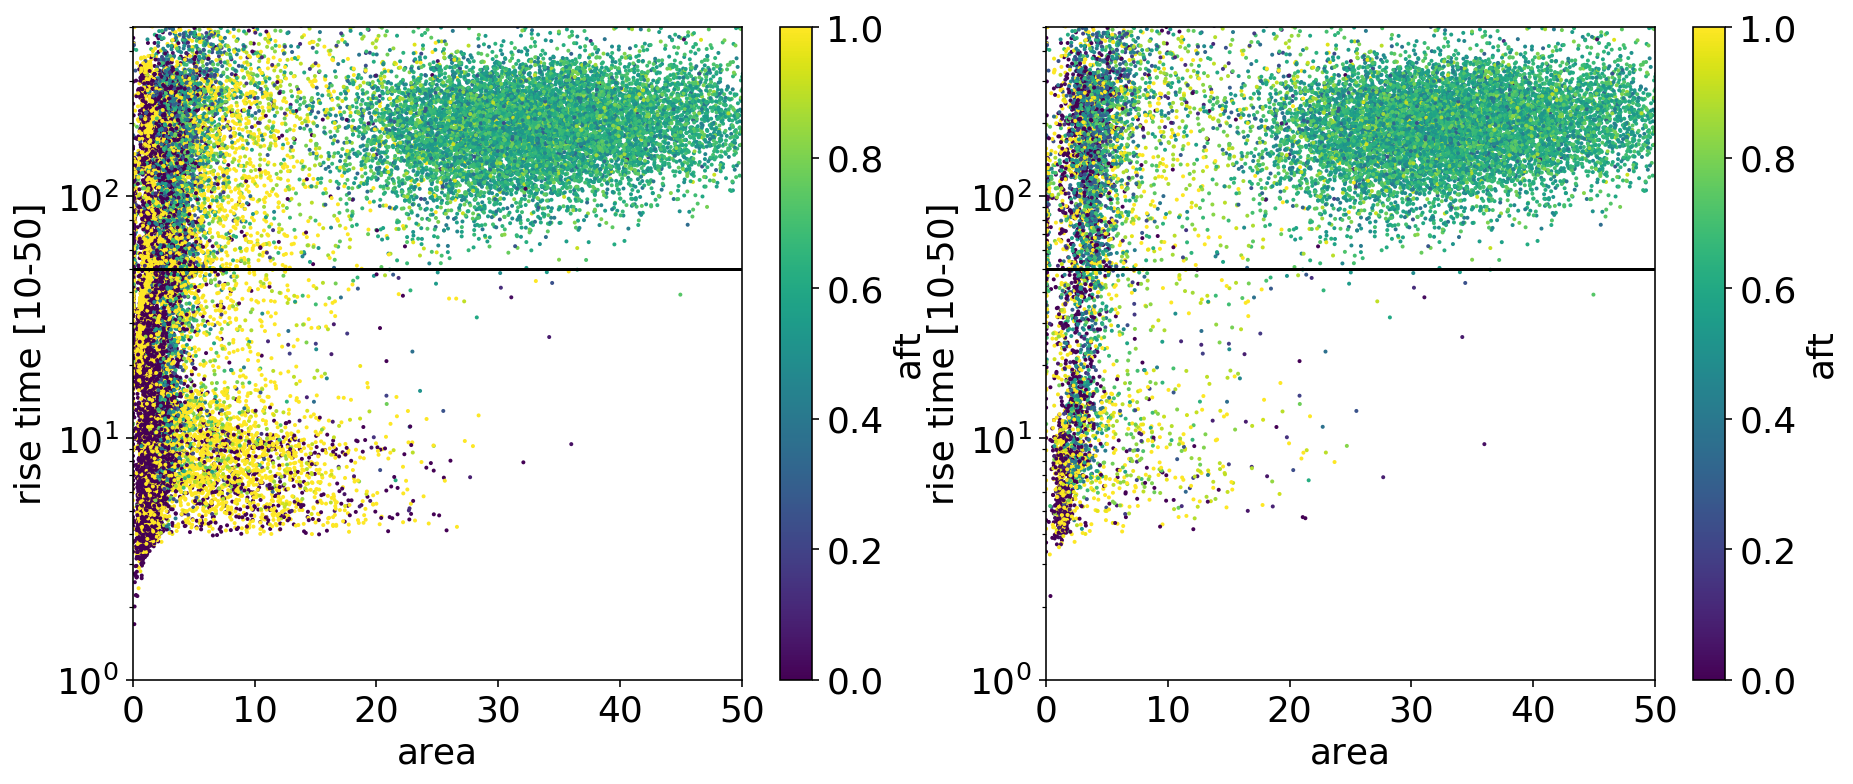

In [13]:
plt.rcParams.update({'font.size': 18})

cut_value = 50

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
plt.scatter(
    peaks_filtered['area'], 
    -1*peaks_filtered['area_decile_from_midpoint'][:,1], 
    c=peaks_filtered['area_fraction_top'],
    s=1
)
plt.axhline(cut_value, color='k')

#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,50])
plt.ylim([1,500])
plt.xlabel('area')
plt.ylabel('rise time [10-50]')
plt.colorbar(label='aft')


ax2 = fig.add_subplot(122)
#p = peaks[(peaks['area_fraction_top']<0.98) & (peaks['area_fraction_top']>0.02)]
p = peaks_filtered[peaks_filtered['n_channels']>2]
plt.scatter(
    p['area'], 
    -1*p['area_decile_from_midpoint'][:,1], 
    c=p['area_fraction_top'],
    s=1
)
plt.axhline(cut_value, color='k')

#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,50])
plt.ylim([1,500])
plt.xlabel('area')
plt.ylabel('rise time [10-50]')
plt.colorbar(label='aft')

plt.show()

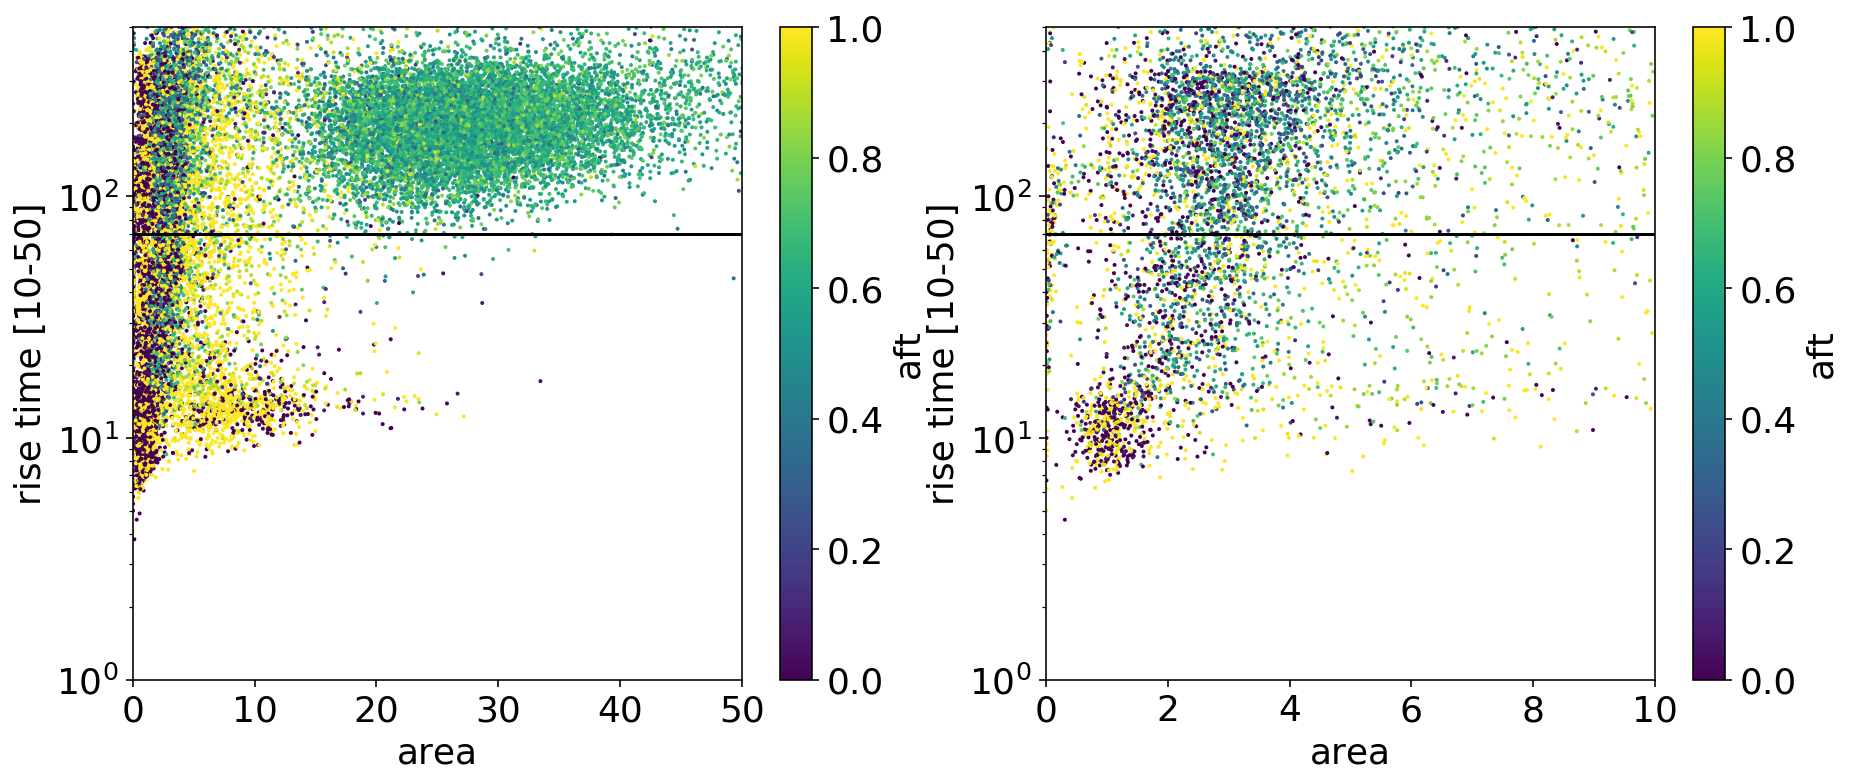

In [17]:
plt.rcParams.update({'font.size': 18})
p = peaks

cut_value = 70

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
plt.scatter(
    p['area'], 
    -1*p['area_decile_from_midpoint'][:,1], 
    c=p['area_fraction_top'],
    s=1
)
plt.axhline(cut_value, color='k')

#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,50])
plt.ylim([1,500])
plt.xlabel('area')
plt.ylabel('rise time [10-50]')
plt.colorbar(label='aft')


ax2 = fig.add_subplot(122)
#p = peaks[(peaks['area_fraction_top']<0.98) & (peaks['area_fraction_top']>0.02)]
p = peaks[peaks['n_channels']>2]
plt.scatter(
    p['area'], 
    -1*p['area_decile_from_midpoint'][:,1], 
    c=p['area_fraction_top'],
    s=1
)
plt.axhline(cut_value, color='k')

#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,10])
plt.ylim([1,500])
plt.xlabel('area')
plt.ylabel('rise time [10-50]')
plt.colorbar(label='aft')

plt.show()

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


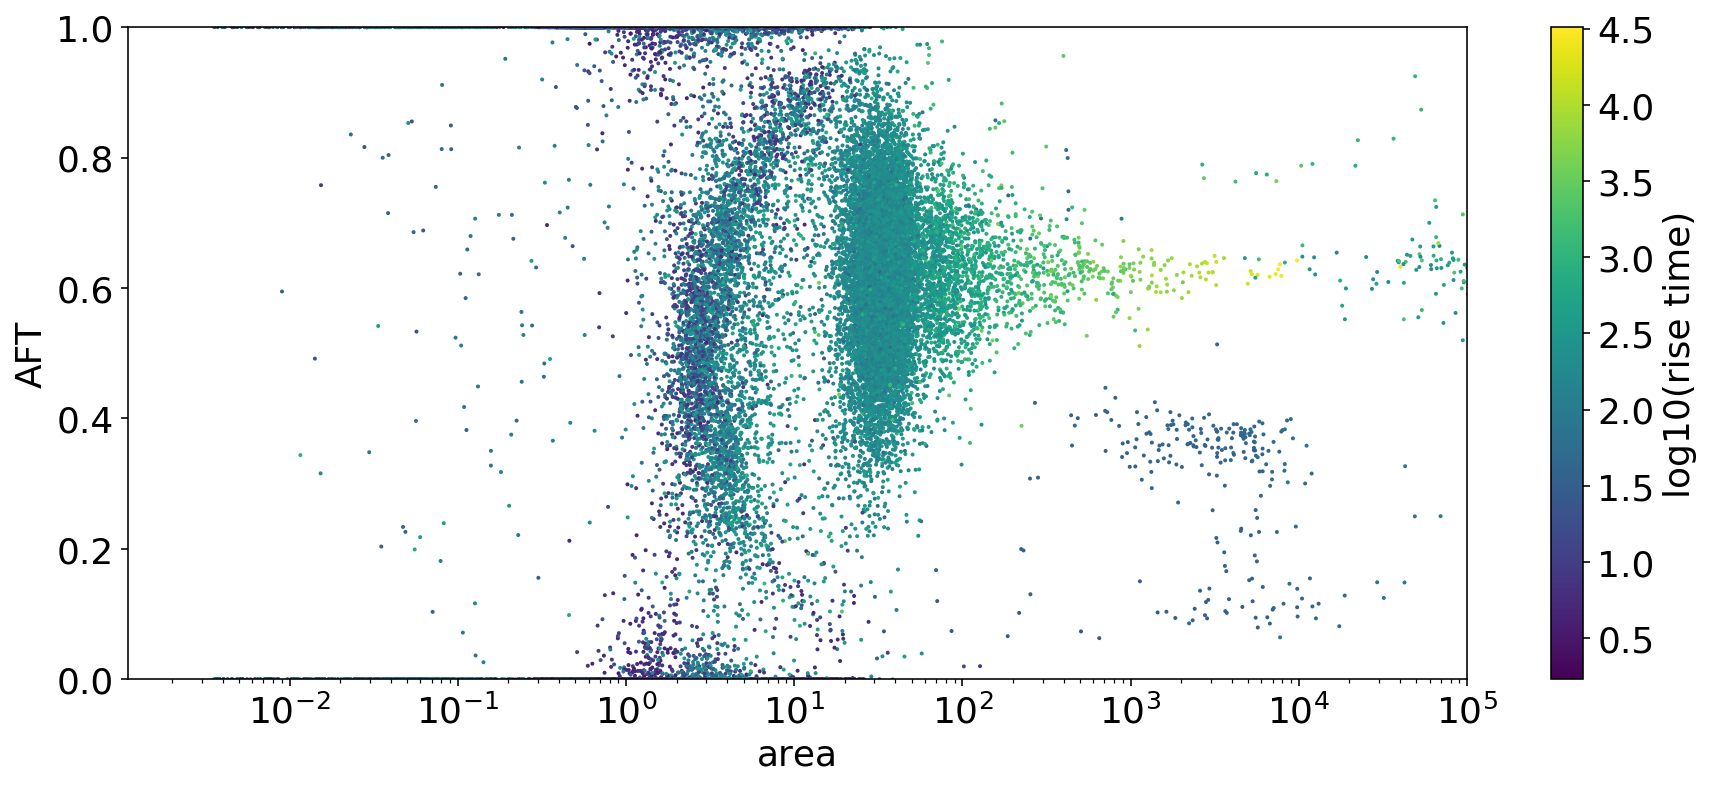

In [61]:
plt.rcParams.update({'font.size': 18})

cut_value = 40

plt.figure(figsize=(15,6))
plt.scatter(
    peaks['area'], 
    peaks['area_fraction_top'], 
    c=np.log10(-1*peaks['area_decile_from_midpoint'][:,1]),
    s=1
)
plt.axhline(cut_value, color='k')

plt.xscale('log')
#plt.yscale('log')
plt.xlim([0,1e5])
plt.ylim([0,1])
plt.xlabel('area')
plt.ylabel('AFT')
plt.colorbar(label='log10(rise time)')

plt.show()

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


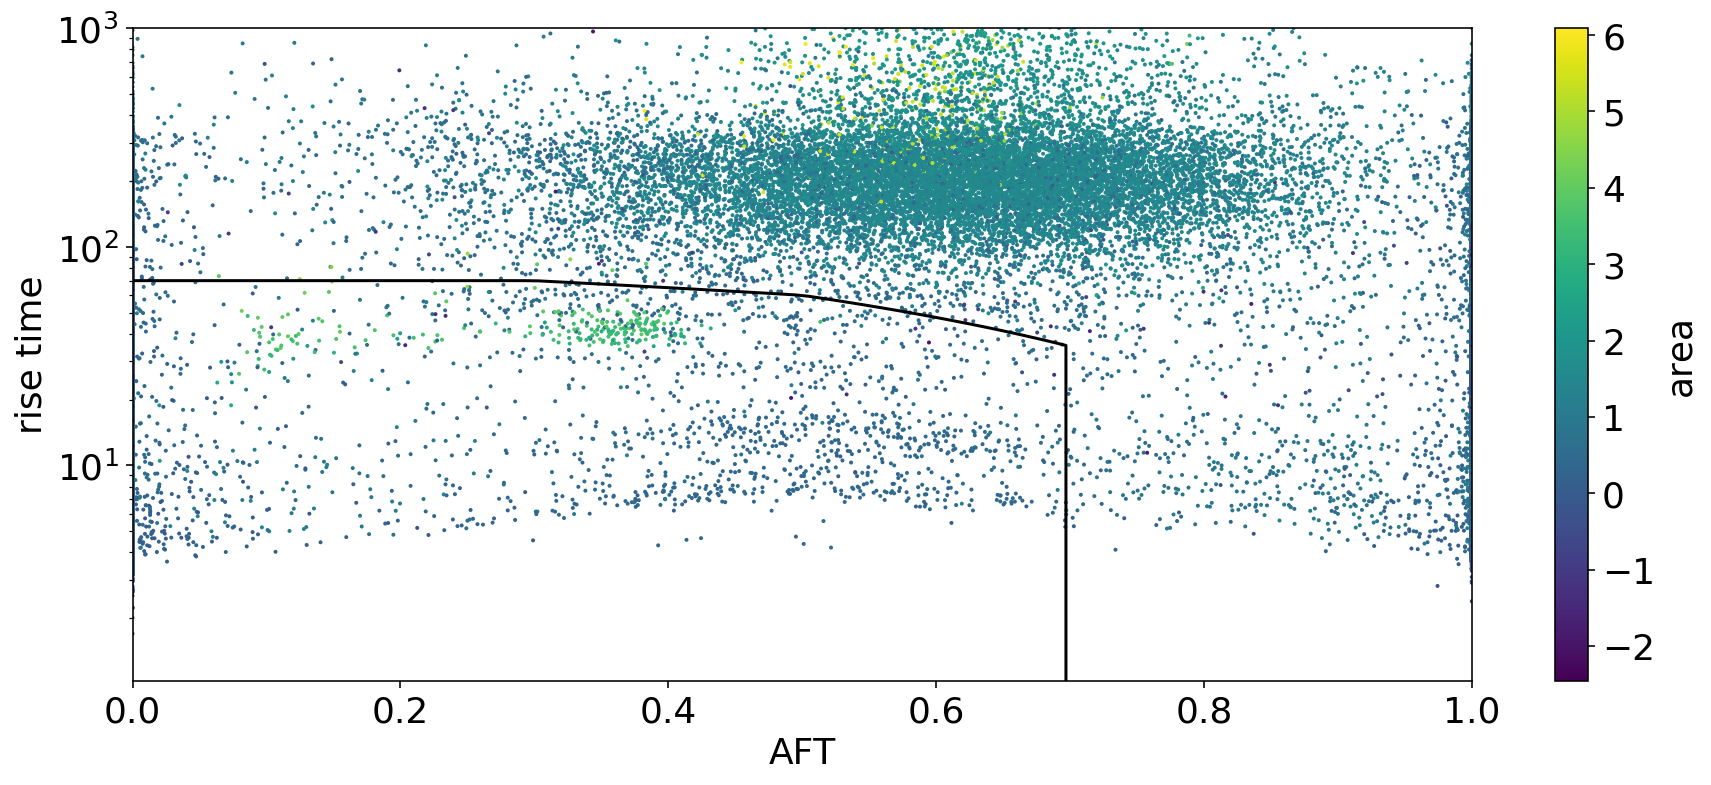

In [53]:
from scipy.interpolate import interp1d
s1_rise_time_aft = interp1d([0, 0.3, 0.4, 0.5, 0.70, 0.70, 1.0],
                                             [70, 70, 65, 60, 35, 0, 0], kind='linear')

plt.rcParams.update({'font.size': 18})

cut_value = 40

plt.figure(figsize=(15,6))
plt.scatter(
    peaks['area_fraction_top'], 
    -1*peaks['area_decile_from_midpoint'][:,1], 
    c=np.log10(peaks['area']),
    s=1
)
xs = np.linspace(0, 1, 100)
plt.plot(xs, s1_rise_time_aft(xs), 'k-')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([0,1e3])
plt.xlim([0,1])
plt.ylabel('rise time')
plt.xlabel('AFT')
plt.colorbar(label='area')

plt.show()

In [79]:
st2 = st.new_context()
st2.register(WorkshopClassification)
st.register(PeakHeight)
st2.register(PeakHeight)

peaks = st2.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification', 'tight_coincidence', 'peak_height'])
peaks_old = st.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification', 'tight_coincidence', 'peak_height'])

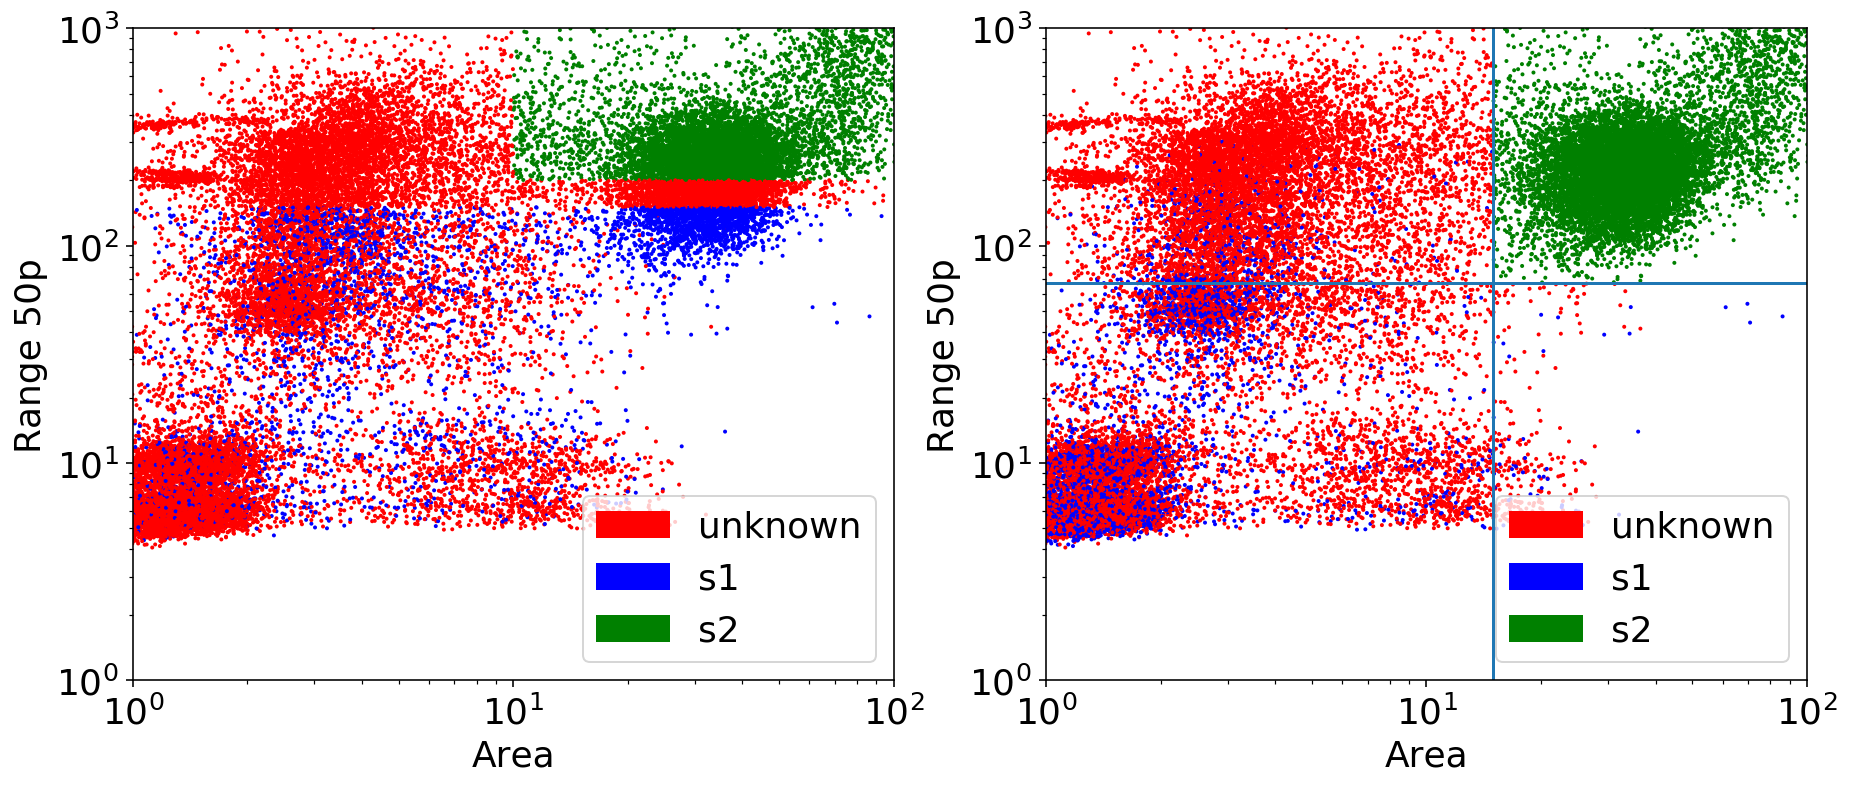

In [80]:
import matplotlib.patches as mpatches
colors = ['r','b','g']
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
plt.scatter(peaks_old['area'], peaks_old['width'][:,5], c=[colors[i] for i in peaks_old['type']], s=1)
labels = ['unknown', 's1', 's2']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.xlabel('Area')
plt.ylabel('Range 50p')

ax2 = fig.add_subplot(122)
plt.scatter(peaks['area'], peaks['width'][:,5], c=[colors[i] for i in peaks['type']], s=1)
labels = ['unknown', 's1', 's2']
plt.axhline(67)
plt.axvline(15)

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e2])
plt.ylim([1, 1e3])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.show()

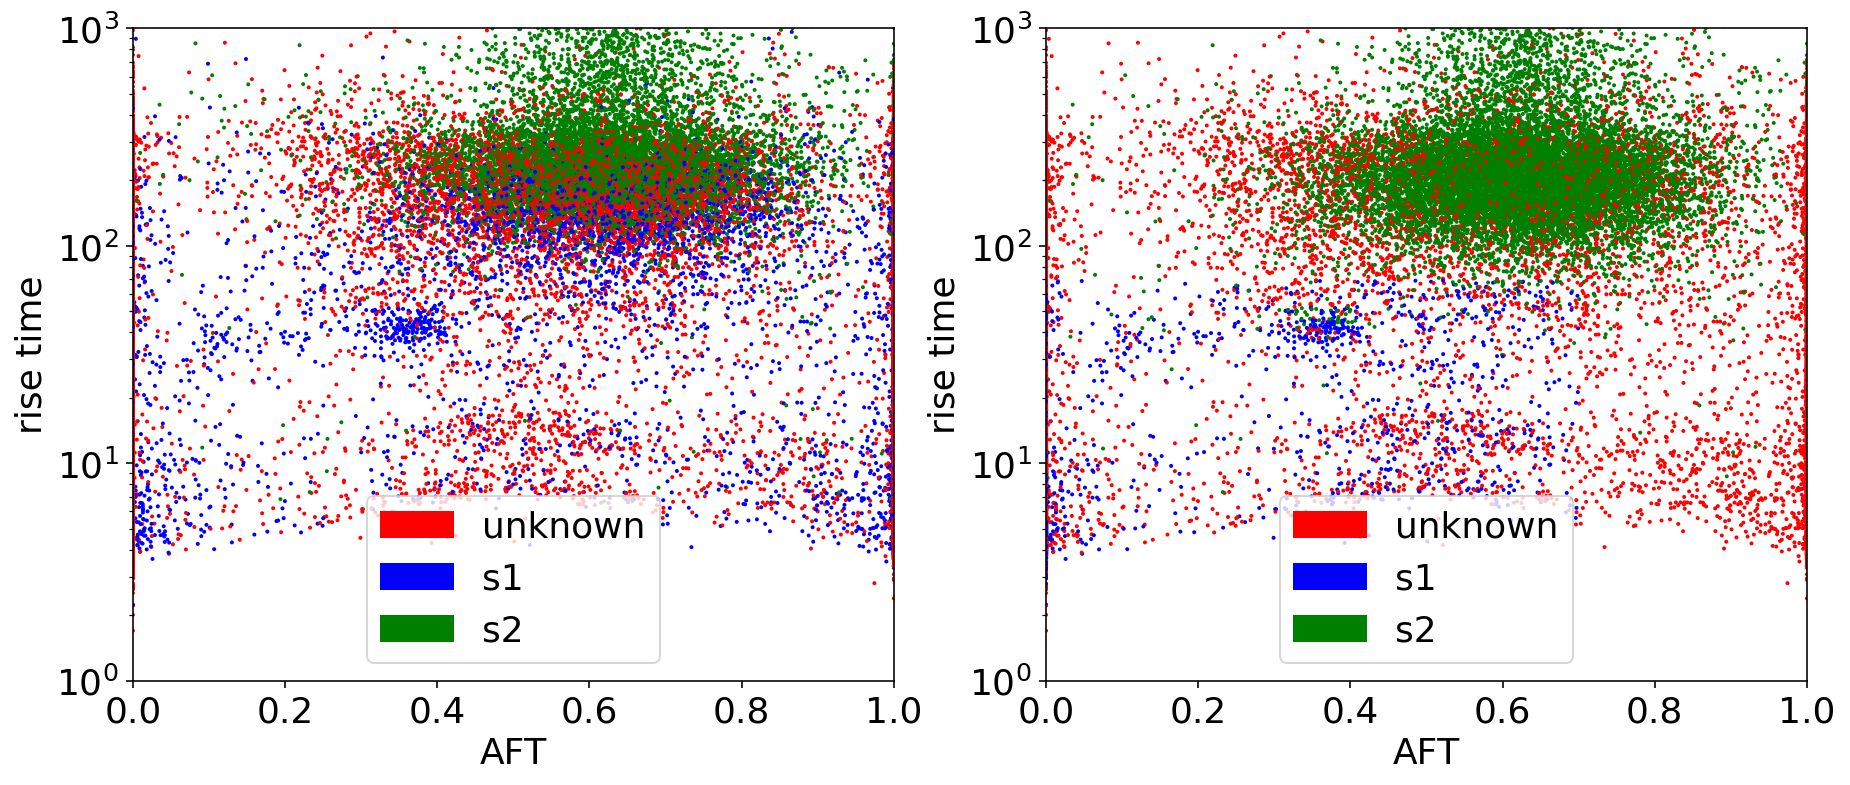

In [81]:
import matplotlib.patches as mpatches
colors = ['r','b','g']
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)


colors = ['r','b','g']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')


plt.scatter(
    peaks_old['area_fraction_top'], 
    -1*peaks_old['area_decile_from_midpoint'][:,1], 
    c=[colors[i] for i in peaks_old['type']],
    s=1
)
plt.yscale('log')
plt.ylim([1,1e3])
plt.xlim([0,1])
plt.ylabel('rise time')
plt.xlabel('AFT')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])


ax2 = fig.add_subplot(122)
plt.scatter(
    peaks['area_fraction_top'], 
    -1*peaks['area_decile_from_midpoint'][:,1], 
   c=[colors[i] for i in peaks['type']],
    s=1
)
xs = np.linspace(0, 1, 100)
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1,1e3])
plt.xlim([0,1])
plt.ylabel('rise time')
plt.xlabel('AFT')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])

plt.show()

ax2 = fig.add_subplot(122)
plt.show()

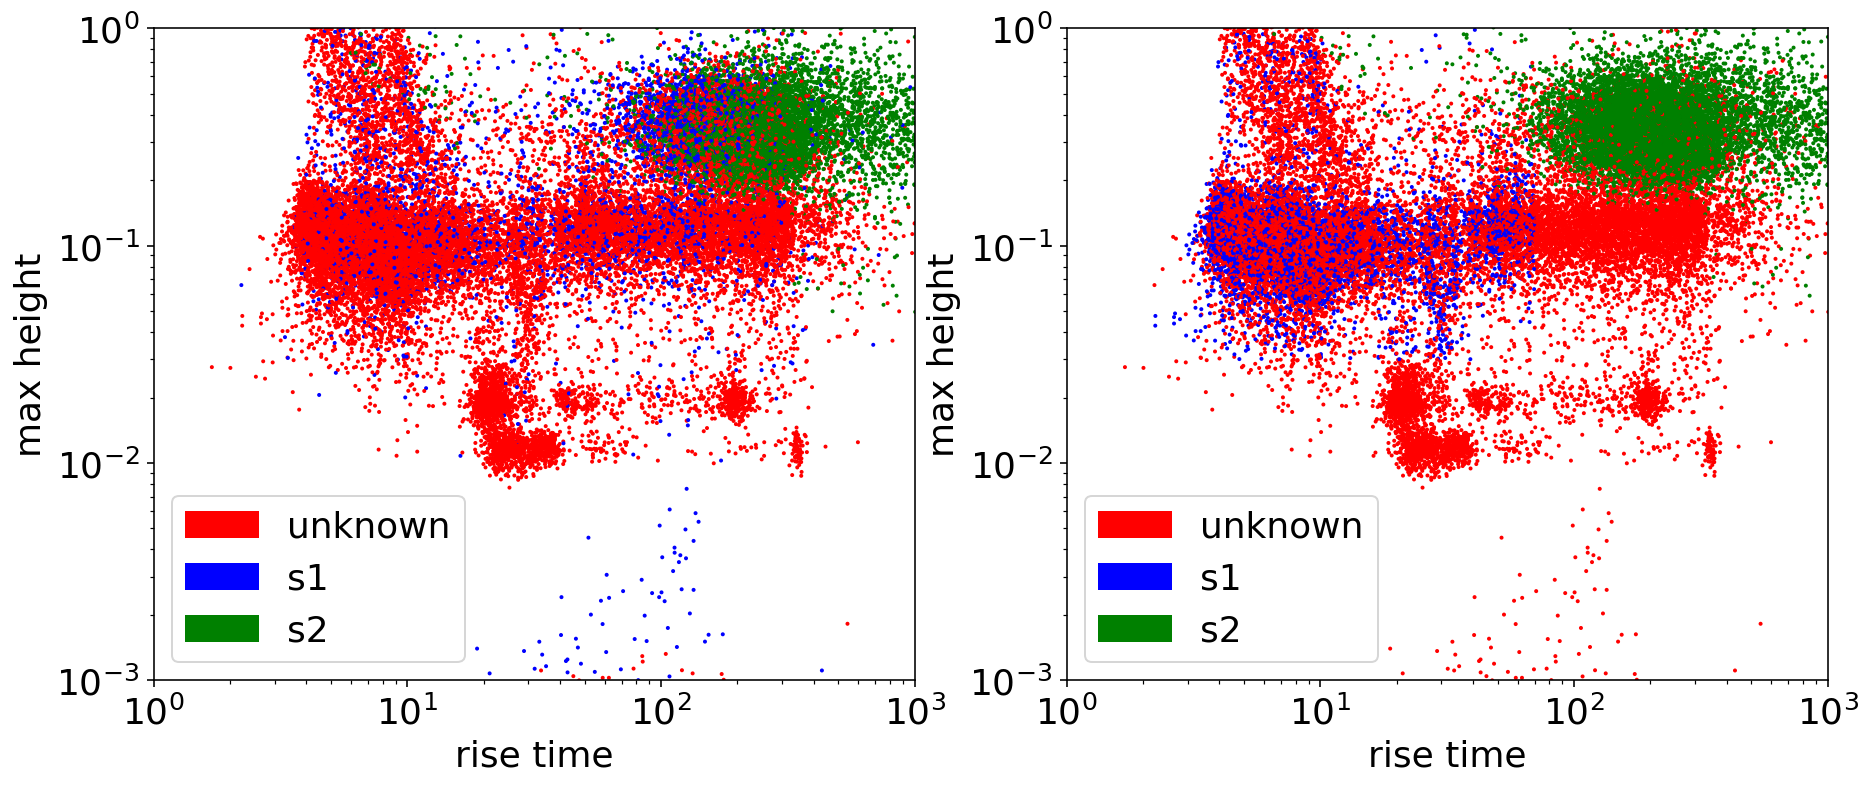

In [85]:
import matplotlib.patches as mpatches
colors = ['r','b','g']
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)


colors = ['r','b','g']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')


plt.scatter(
    -1*peaks_old['area_decile_from_midpoint'][:,1], 
    peaks_old['maxheight'], 
    c=[colors[i] for i in peaks_old['type']],
    s=1
)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1,1e3])
plt.ylim([0.001,1])
plt.xlabel('rise time')
plt.ylabel('max height')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])


ax2 = fig.add_subplot(122)
plt.scatter(
    -1*peaks['area_decile_from_midpoint'][:,1], 
    peaks['maxheight'], 
   c=[colors[i] for i in peaks['type']],
    s=1
)
xs = np.linspace(0, 1, 100)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1e3])
plt.ylim([0.001,1])
plt.xlabel('rise time')
plt.ylabel('max height')
plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])

plt.show()

ax2 = fig.add_subplot(122)
plt.show()